# PLY216 OBSERVATIONAL IBRE JUPYTER REPORT

## PROCEDURE 

Table 1. Abstract trial type during the training and test phase

| Training (Relative Frequencies) | Test |
| --- | --- |
| $AB \to common_{1}$ (x 3) |  A, B, C, AB, AC |
| $AC \to rare_{1}$   (x 1) |  BC |

Participants were asked to learn about symptoms and diseases and then to make some judgements about new combinations of symptoms.
Abstract stimuli for both training and test phases are in Table 1.
In the first phase, participants saw descriptions of patients, such as the one below:

> Janet has fever and nausea that belongs to Disease Z.

They had 10 seconds to study these descriptions before moving on to the next trial.
They were also allowed to move on from the current trial by pressing space.
Overall, there were 40 patients uniformly distributed into 5 blocks of 8 patients, but participants did not have to complete all 5 blocks.
After the second block, they were allowed to skip the rest of the learning phase and move on to the test phase.

In the test phase, participants then saw only the symptoms and were asked to classify them into diseases by pressing Z for Disease Z and L for Disease L.
They had 10 seconds to do this.


## ANALYSIS

We observe IBRE, when $BC \to Rare > BC \to Common$.
In plain words, we observe IBRE when participants sort the compound of uniquely predictive features into the rare category more often than into the common category.
We tested this inequality by comparing the two groups of observations ($BC \to Rare$ vs $BC \to Common$) by Bayesian Parameter 
Estimation as outlined by @kruschke2011doing and implemented in the R package `BEST` [@kruschke2021BEST].
We used the default settings of `BESTmcmc` when comparing the two groups of observations.
We defined the Region Of Practical Equivalence (ROPE) to be the interval of (-0.1, 0.1).
If more than 75% of the posterior distribution of the differences falls outside of ROPE, we conclude that we have observed the inverse base-rate effect.


In [1]:
import pandas as pd
import numpy as np
import pymc3 as pm
import best
import arviz as az
import matplotlib.pyplot as plt
import glob
%matplotlib inline

In [2]:
az.style.use("arviz-darkgrid")
rng = np.random.default_rng(seed=42)

# import all data
files = glob.glob("../data/raw/*.csv")

# this is a bit dense but essentially it is a for loop where the looping
# comes last and the commands first
dta = pd.concat([pd.read_csv(f) for f in files])
dta['symptom2'] = dta['symptom2'].replace('NaN', np.nan).fillna('')
dta['stim'] = dta['symptom1'].astype(str) + dta['symptom2'].astype(str)
dta['stim'] = dta['stim'].astype('category')

stim_map = {'A' : 'A',
            'B' : 'B',
            'C' : 'C',
            'AB' : 'AB',
            'AC' : 'AC',
            'BA' : 'AB',
            'BC' : 'BC',
            'CA' : 'AC',
            'CB' : 'BC'}

## recode physical stim to abstract stim
dta['abstim'] = dta['stim'].map(stim_map)

## get test data
test = dta[dta['phase'] == 'test'][['ppt', 'abstim', 'abresp']]
## group and count data plus make sure it is a DataFrame with reset_index
## unstack and fill value makes sure that each participant has both common and rare value
test = test.groupby(['ppt', 'abstim', 'abresp']).size().unstack(fill_value = 0).reset_index()
test = pd.melt(test, id_vars=['ppt', 'abstim'], var_name='abresp')
## turn counts into probabilities
test['prob'] = test['value'] / 20


### GROUP-LEVEL ANALYSIS

In [3]:
test.groupby(['abstim', 'abresp']).mean()

value      prob
abstim abresp                     
A      common  12.521368  0.626068
       none     0.059829  0.002991
       rare     7.589744  0.379487
AB     common  16.743590  0.837179
       none     0.008547  0.000427
       rare     3.418803  0.170940
AC     common   3.341880  0.167094
       none     0.025641  0.001282
       rare    16.803419  0.840171
B      common  16.726496  0.836325
       none     0.008547  0.000427
       rare     3.435897  0.171795
BC     common   7.905983  0.395299
       none     0.085470  0.004274
       rare    12.179487  0.608974
C      common   3.205128  0.160256
       none     0.025641  0.001282
       rare    16.940171  0.847009

In [4]:
bc_rare = test.loc[(test['abstim'] == 'BC') & (test['abresp'] == 'rare')]['prob']
bc_common = test.loc[(test['abstim'] == 'BC') & (test['abresp'] == 'common')]['prob']

best_out = best.analyze_two(bc_rare, bc_common)

/home/lenarddome/.local/lib/python3.8/site-packages/best/model.py:78: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(n_samples, **kwargs)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Group 2 log sigma, Group 1 log sigma, nu - 2.5, Group 2 mean, Group 1 mean]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 5 seconds.


/home/lenarddome/.local/lib/python3.8/site-packages/best/plot.py:456: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.tight_layout()
<ipython-input-5-0369e31e0301>:2: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


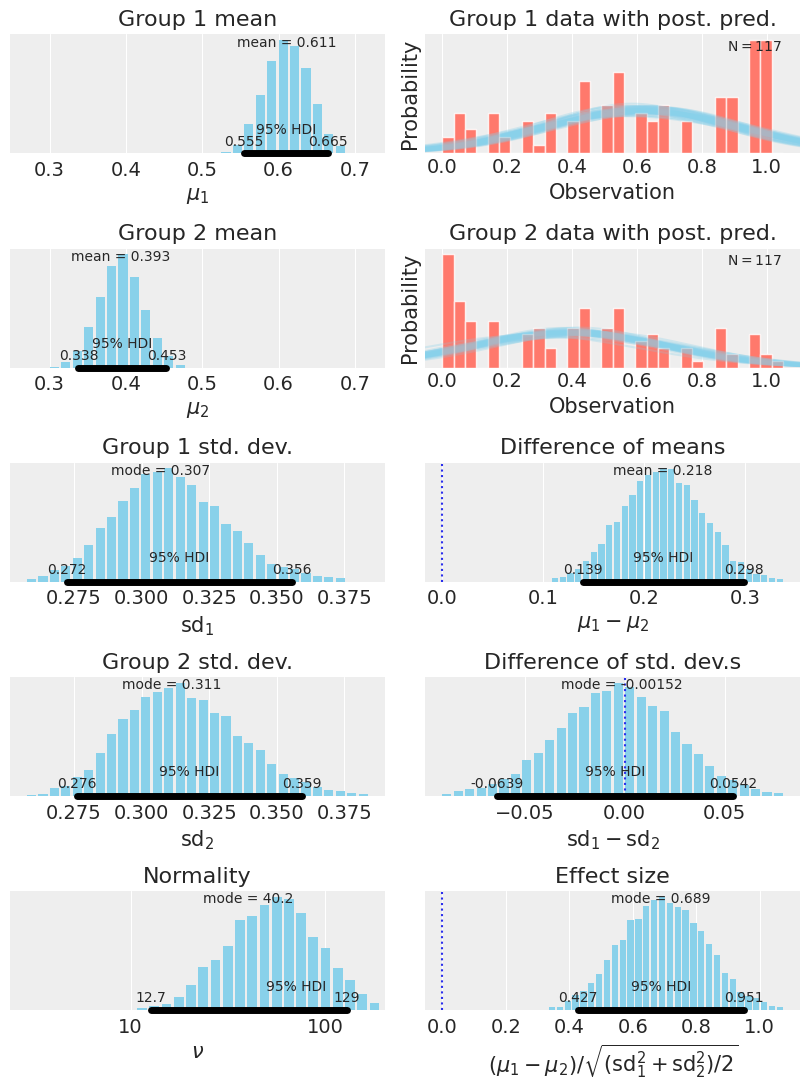

In [5]:
fig = best.plot_all(best_out)
fig.show()

The figure above shows some general descriptive statistics of the Bayesian Parameter Estimation - given you ran the cell. The interesting bit of the graph is the difference of means, which relates to the actual test we are doing - wether there is a difference between common vs rare. In order to fully use Kruschke's method, we need to calcualte how much of the posterior distribution of differences lies outside the region of practical equivalence, ROPE. Currently, no one has implemented the method in python, so I quickly calculated it below using from 95% HDI. 

In [6]:
## Calculate ROPE
posterior = best_out.hdi('Difference of means', 0.95)
posterior = np.asarray(posterior)
unit = (posterior[1] - posterior[0]) / 100

if posterior[0] > 0.10 :
    print("100% of posterior is outside of ROPE.")
else:
    rope = (0.10 - posterior[0]) / unit
    print(str(rope) + " of posterior is inside of ROPE.")


100% of posterior is outside of ROPE.


This means that if we define ROPE as $[-0.10, 0.10]$, 100% of the 95% HDI falls outside of ROPE. This is substantial evidence for the presence of IBRE.